## 環境
- OS: Ubuntu 22.04.3 LTS
- CPU: AMD Ryzen 7 5700X 8-Core Processor
- GPU: NVIDIA GeForce RTX 3060 Ti
- メモリ: 32GB
- Python: 3.9.21 (conda環境)

## ライブラリ

In [10]:
# 使用するライブラリ

import os

from chembl_webresource_client.new_client import new_client
from molvs.charge import Uncharger
import numpy as np
import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem.MolStandardize import rdMolStandardize
import matplotlib.pyplot as plt

## データ取得: ChEMBL

In [11]:
# ChEMBLからデータを取得する
activity = new_client.activity
act = activity.filter(standard_type='LogD', standard_relation='=', )
len(act)

27337

In [12]:
# データをpandasのDataFrameに格納する（時間がかかる）
df = pd.DataFrame.from_records(act)

In [13]:
# データをcsvとして保存する
os.makedirs('~/shaeo-blog/pj-logd/dataset', exist_ok=True)
df.to_csv('~/shaeo-blog/pj-logd/dataset/chembl_logd.csv')

## クレンジング

### pH7.4の実験条件で取得されたデータの抽出

In [56]:
# データの読み込み
df = pd.read_csv('~/shaeo-blog/pj-logd/dataset/chembl_logd.csv')

# standard_valueが欠損しているデータを削除
df = df[~df['standard_value'].isna()]   # standard_value列の欠損値以外のデータを抽出

# pH7.4条件の抽出
filtered_df = df[df['assay_description'].str.contains('7.4', na=False)] # assay_description列に'7.4'が含まれる行を抽出
print('pH7.4条件抽出前のデータ数: ', len(df))
print('pH7.4条件抽出後のデータ数: ', len(filtered_df))

pH7.4条件抽出前のデータ数:  27326
pH7.4条件抽出後のデータ数:  18091


/tmp/ipykernel_1093091/152355568.py:2: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('~/shaeo-blog/pj-logd/dataset/chembl_logd.csv')


### 構造情報の標準化（塩の測定データの除去、イオンの中和）

In [57]:
# 塩が含まれるかどうかを判定する関数
def has_salt(smi):

    # もとのSMILESをRDkitのcanonical表現に変換
    try:
        mol = Chem.MolFromSmiles(smi)
        original_smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
    except:
        return np.nan

    # 分子内の最大フラグメントを抽出する
    parent_mol = rdMolStandardize.FragmentParent(mol)
    
    # 最大フラグメント抽出後のSMILES
    parent_smiles = Chem.MolToSmiles(parent_mol)

    return original_smiles != parent_smiles # 変化したかどうかを判定

# 塩を判定するカラムを追加
filtered_df['has_salt'] = filtered_df['canonical_smiles'].map(has_salt)
print('塩の化合物数: ', (filtered_df['has_salt']==True).sum())
print('RDkitでの読み込みに失敗した化合物数: ', filtered_df['has_salt'].isna().sum())

# 塩以外のデータを抽出
filtered_df2 = filtered_df[filtered_df['has_salt']==False]

# 中和で構造情報が変わるかどうかを判定する関数
def check_neutlized(smi):

    # もとのSMILESをRDkitのcanonical表現に変換
    mol = Chem.MolFromSmiles(smi)
    original_smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)

    # 構造を中和する
    neutlized_mol = uncharger(mol)
    neutlized_smiles = Chem.MolToSmiles(neutlized_mol) # 中和後のSMILES

    return original_smiles != neutlized_smiles # 変化したかどうかを判定

# 中和を判定するカラムを追加
filtered_df2['change_neutlized_flag'] = filtered_df2['canonical_smiles'].map(check_neutlized)
print('中和された化合物数: ', (filtered_df2['change_neutlized_flag']==True).sum())

# 構造情報を中和する
filtered_df2['canonical_smiles'] = filtered_df2['canonical_smiles'].map(lambda x: Chem.MolToSmiles(uncharger(Chem.MolFromSmiles(x)), isomericSmiles=True, canonical=True))

print('標準化前のデータ数: ', len(filtered_df))
print('標準化後のデータ数: ', len(filtered_df2))

/tmp/ipykernel_1093091/4080925054.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['has_salt'] = filtered_df['canonical_smiles'].map(has_salt)


塩の化合物数:  700
RDkitでの読み込みに失敗した化合物数:  35


/tmp/ipykernel_1093091/4080925054.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df2['change_neutlized_flag'] = filtered_df2['canonical_smiles'].map(check_neutlized)


中和された化合物数:  0
標準化前のデータ数:  18091
標準化後のデータ数:  17356


/tmp/ipykernel_1093091/4080925054.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df2['canonical_smiles'] = filtered_df2['canonical_smiles'].map(lambda x: Chem.MolToSmiles(uncharger(Chem.MolFromSmiles(x)), isomericSmiles=True, canonical=True))


### 重複データの処理

In [58]:
# SMILESが重複する行の処理

# canonical_smiles列でグルーピングして、各グループのstandard_valueを平均する
filtered_df3 = filtered_df2.groupby('canonical_smiles', as_index=False)['standard_value'].mean()
filtered_df3

,canonical_smiles,standard_value
0,Brc1c(NC2=NCCN2)ccc2nccnc12,0.31
1,Brc1cc(Br)c(N=C2NCCN2)c(Br)c1,2.51
2,Brc1ccc(-c2nc(-c3ccc4nc[nH]c4c3)no2)cc1,3.54
3,Brc1ccc(Br)c(N(CC2CC2)C2=NCCN2)c1,-0.52
4,Brc1ccc(Cc2nn[nH]n2)cc1,-0.42
...,...,...
16296,c1nc(N[C@H]2CC[C@H](N3CCOCC3)CC2)c2c(C3CCOCC3)...,1.50
16297,c1nc(N[C@H]2CC[C@H](N3CCOCC3)CC2)c2c(C3CCOCC3)...,1.90
16298,c1nc(OC2CCN(Cc3cscn3)CC2)c2ccn(CC3CCCCC3)c2n1,4.32
16299,c1nc(O[C@H]2CC[C@H](N3CCOCC3)CC2)c2c(C3CCOCC3)...,2.40


LogD standard_value:  4872.0


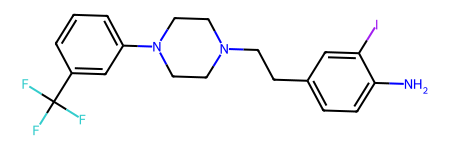

In [63]:
# LogDの最大値を持つ化合物
print('LogD standard_value: ', filtered_df3.sort_values(by='standard_value').iloc[-1, 1])
Chem.MolFromSmiles(filtered_df3.sort_values(by='standard_value').iloc[-1, 0])

LogD standard_value:  -13.29


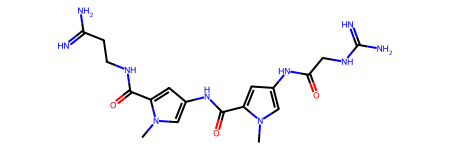

In [64]:
# LogDの最小値を持つ化合物
print('LogD standard_value: ', filtered_df3.sort_values(by='standard_value').iloc[0, 1])
Chem.MolFromSmiles(filtered_df3.sort_values(by='standard_value').iloc[0, 0])

### 外れ値の除去

In [66]:
# 外れ値の除去

# IQR（四分位範囲）と最大・最小値の計算
q1 = filtered_df3['standard_value'].quantile(0.25) #Q1（第一四分位数）
q3 = filtered_df3['standard_value'].quantile(0.75) #Q3（第三四分位数）
_min = filtered_df3['standard_value'].min()
_max = filtered_df3['standard_value'].max()
iqr = q3 -q1
print('*'*100)
print('外れ値除去前の最大値: ', _min)
print('外れ値除去前の最大値: ', _max)
print('外れ値除去前の第一四分位数: ', q1)
print('外れ値除去前の第三四分位数: ', q3)
print('*'*100)

# 外れ値の除去: (Q1 - 1.5*IQR) ~ (Q3 + 1.5*IQR) の範囲から外れるものを外れ値として扱う
filtered_df4 = filtered_df3.query('(@q1 - 1.5 * @iqr <= standard_value <= @q3 + 1.5 * @iqr)')
filterd_q1 = filtered_df4['standard_value'].quantile(0.25) #Q1（第一四分位数）
filterd_q3 = filtered_df4['standard_value'].quantile(0.75) #Q3（第三四分位数）
filterd_min = filtered_df4['standard_value'].min()
filterd_max = filtered_df4['standard_value'].max()
print('外れ値除去後の最大値: ', filterd_min)
print('外れ値除去後の最大値: ', filterd_max)
print('外れ値除去後の第一四分位数: ', filterd_q1)
print('外れ値除去後の第三四分位数: ', filterd_q3)
print('*'*100)
print('外れ値除去前のデータ数: ', len(filtered_df3))
print('外れ値除去後のデータ数: ', len(filtered_df4))

****************************************************************************************************
外れ値除去前の最大値:  -13.29
外れ値除去前の最大値:  4872.0
外れ値除去前の第一四分位数:  1.52
外れ値除去前の第三四分位数:  3.3499999999999996
****************************************************************************************************
外れ値除去後の最大値:  -1.22
外れ値除去後の最大値:  6.09
外れ値除去後の第一四分位数:  1.6
外れ値除去後の第三四分位数:  3.3
****************************************************************************************************
外れ値除去前のデータ数:  16301
外れ値除去後のデータ数:  15746


### データの保存

In [67]:
# データの保存
filtered_df4.to_csv('~/shaeo-blog/pj-logd/dataset/chembl_logd_crensing.csv', index=False)

## データ分割
- 訓練データとテストデータを1:1に分割（random split）。
- 目的変数によっては特徴量による分割等の方がより実践的な精度を確認できる。LogDは分割方法で精度が変わりづらい印象があるので今回はランダムに分割。
- ヒストグラムは分布に偏りがないか確認するために作成。

In [77]:
# データの読み込み
df = pd.read_csv('~/shaeo-blog/pj-logd/dataset/chembl_logd_crensing.csv')

# データの分割
df_train = df.sample(frac=0.5, random_state=42)
df_test = df.drop(index=df_train.index)

# データの保存
df_train.to_csv('~/shaeo-blog/pj-logd/dataset/train.csv', index=False)
df_test.to_csv('~/shaeo-blog/pj-logd/dataset/test.csv', index=False)

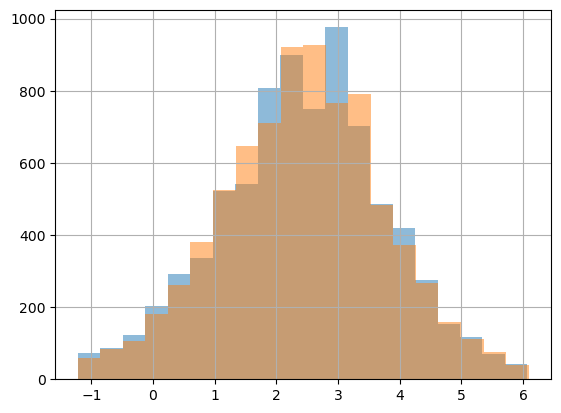

In [80]:
# ヒストグラムによる分布の確認

df_train['standard_value'].hist(bins=20, alpha=0.5)
df_test['standard_value'].hist(bins=20, alpha=0.5)

plt.show()